In [ ]:
#pip install chardet

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras import layers
import random
import os
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import chardet

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
seed = 42

# Random seed function
def set_random_seeds(seed: int):
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seeds(seed=42)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/music_recommendation/data/training_final.csv.zip" -d "/content/drive/My Drive/music_recommendation/data/"

Archive:  /content/drive/My Drive/music_recommendation/data/training_final.csv.zip
  inflating: /content/drive/My Drive/music_recommendation/data/training_final.csv  


# Data & Premliminary Stats

In [5]:
PATH = '/content/drive/My Drive/music_recommendation/data/'

In [6]:
train = pd.read_csv(PATH + 'train.csv')

In [7]:
df_members = pd.read_csv(PATH + 'members.csv')
df_song_extra_info = pd.read_csv(PATH + 'song_extra_info.csv')
df_songs = pd.read_csv(PATH + 'songs.csv')

In [8]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [10]:
df_songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [11]:
df_members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


Dataset Shape

In [9]:
print("train shape", train.shape)
print("members shape", df_members.shape)
print("song shape", df_songs.shape)
print("song extra info shape", df_song_extra_info.shape)

train shape (7377418, 6)
members shape (34403, 7)
song shape (2296320, 7)
song extra info shape (2295971, 3)


In [10]:
print("*"*5, "training data info", "*"*5)
print(train.info())
print(" ")
print("*"*5,"members data info", "*"*5)
print(df_members.info())
print(" ")
print("*"*5, "song data info", "*"*5)
print(df_songs.info())
print(" ")
print("*"*5, "song extra info", "*"*5)
print(" ")
print(df_song_extra_info.info())

***** training data info *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB
None
 
***** members data info *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-n

In [11]:
train_temp = pd.merge(train, df_songs, on='song_id', how='left')
df_train = pd.merge(train_temp, df_members, on='msno', how='left')

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   song_length             float64
 7   genre_ids               object 
 8   artist_name             object 
 9   composer                object 
 10  lyricist                object 
 11  language                float64
 12  city                    int64  
 13  bd                      int64  
 14  gender                  object 
 15  registered_via          int64  
 16  registration_init_time  int64  
 17  expiration_date         int64  
dtypes: float64(2), int64(6), object(10)
memory usage: 1.0+ GB


In [16]:
df_train.duplicated().sum()

0

# Handling Missing Data

In [12]:
dtypes = pd.DataFrame(df_train.dtypes,columns=["Data Type"])

dtypes["Unique Values"]=df_train.nunique().sort_values(ascending=True)

dtypes["Null Values"]=df_train.isnull().sum()

dtypes["% Null Values"]=df_train.isnull().sum()/len(df_train)

dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

,Data Type,Unique Values,Null Values,% Null Values
lyricist,object,33888,3178798,0.430882
gender,object,2,2961479,0.401425
composer,object,76064,1675706,0.227140
source_screen_name,object,20,414804,0.056226
genre_ids,object,572,118455,0.016056
source_system_tab,object,8,24849,0.003368
source_type,object,12,21539,0.002920
language,float64,10,150,0.000020
song_length,float64,60266,114,0.000015
artist_name,object,40582,114,0.000015



1.   As there are a lot of null values in the categorical columns, we can't just decide to delete the rows. A solution could be replace the String values with the string "Unknown".
2.  The length of the songs is replaced with the median value.
3.  Concerning the language, instead of just deleting the records of the songs that has null language, I try to retrieve the language of the song from the song names. The data description provided in the task doesn't really explain the mappings of the languages. The language is a numerical features but with do not know to which language it corresponds. However, we can derive this informations by looking at the songs name.   All english/american songs have the language code 52.0 - thus we can provide the code 52 to english songs. Instead, asian songs have the code 3. For convenience, songs in other languages are deleted because a brief analysis of the values shows that these songs have only been listened to once, have many 'Unknown' values, making the record very uninformative.

In [13]:
#fill categorical features with unknown
cat_features = df_train.select_dtypes(include=['object']).columns.tolist()

for i in cat_features:
    df_train[i].fillna("Unknown", inplace=True)

# Replace missing values in song_length with its median
median_song_length = df_train['song_length'].median()
df_train['song_length'].fillna(median_song_length, inplace=True)

**MAPPING OF SONG** - Look at the name of the songs, analyse their language, and then find to which language number it corresponds.
- Japanese: 17.0
- Indian: 38.0
- Japanese: 17.0
- Indian: 38.0
- Mandarin Chinese: 3.0
- Chinese Variations: 59.0, 10.0 (Simplified Chinese), 24.0
- Korean: 31
- English: 52
- Taiwanese: 45.0
- Mixed languages: (italian, french,..) -1.0

In [ ]:
#sample code for mapping song names with nan language to their language:
#result = df_train.merge(df_song_extra_info, on='song_id', how='left')
#result[result['language'] == -1.0]

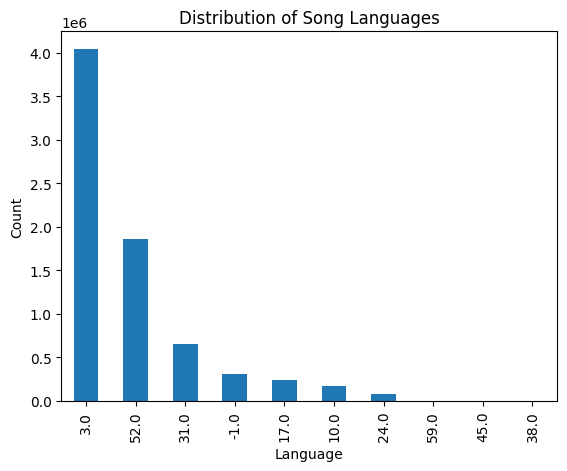

In [14]:
#Analysis on the most frequent language
df_train['language'].value_counts().plot(kind='bar')
plt.title('Distribution of Song Languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

In [15]:
songs_with_nulls = df_train[df_train.isnull().any(axis=1)]
result = songs_with_nulls.merge(df_song_extra_info, on='song_id', how='left')
song_list = result['name'].unique().tolist()

In [16]:
def detect_encoding(name):
    try:
        detected = chardet.detect(name.encode())['encoding']
        if detected == 'ascii':
            return 'english'
        elif detected in ['utf-8', 'EUC-KR', 'EUC-JP']:
            return 'asian'
        else:
            return 'other'
    except:
        return 'other'

def update_language_based_on_song_name(song_names, df_training, df_song_extra_info):
    # Merge the datasets
    merged_df = pd.merge(df_training, df_song_extra_info[['song_id', 'name']], on='song_id', how='left')

    # List of keywords for Italian, Korean, Russian, and French songs
    delete_keywords = ['Questa', 'Notte', 'homme', 'faut', 'Малыш']

    rows_to_delete = []

    # Iterate through the merged dataframe
    for index, row in tqdm(merged_df.iterrows()):
        song_name = row['name']
        if isinstance(song_name, str) and song_name in song_names:
            # Check for keywords that indicate we should delete the row
            if any(keyword in song_name for keyword in delete_keywords):
                rows_to_delete.append(index)
                continue

            # Determine the song's language using encoding detection
            song_language = detect_encoding(song_name)

            if song_language == 'english':
                merged_df.at[index, 'language'] = 52.0
            elif song_language == 'asian':
                merged_df.at[index, 'language'] = 3.0

    # Drop the rows with unwanted songs
    merged_df.drop(rows_to_delete, inplace=True)

    # Drop the 'name' column as it was not originally in the df_training dataframe
    merged_df.drop(columns=['name'], inplace=True)

    return merged_df

df_train = update_language_based_on_song_name(song_list, df_train, df_song_extra_info)

7377418it [05:21, 22918.78it/s]


In [17]:
df_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,Unknown,52.0,1,0,Unknown,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,Unknown,Unknown,52.0,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,Unknown,52.0,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,Unknown,-1.0,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,Unknown,52.0,1,0,Unknown,7,20120102,20171005


In [27]:
df_train.isna().sum()

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
song_length               0
genre_ids                 0
artist_name               0
composer                  0
lyricist                  0
language                  0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
dtype: int64

# EDA

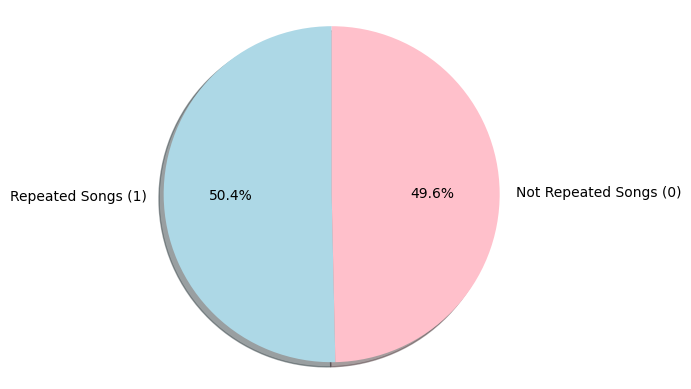

In [18]:
labels = "Repeated Songs (1)", "Not Repeated Songs (0)"

fig1, ax1 = plt.subplots()
ax1.pie(df_train['target'].value_counts(), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=["Lightblue", "Pink"] )
ax1.axis('equal')
plt.show()

There are attributes containing the | or some other separator to separate artist, composer and lyricist names.

In [19]:
# Split, flatten, and remove whitespace
all_values_composer = df_train['composer'].str.split(r'[、|,/]').explode().str.strip().unique()
all_values_artist = df_train['artist_name'].str.split(r'[、|,/]').explode().str.strip().unique()
all_values_lyricist = df_train['lyricist'].str.split(r'[、|,/]').explode().str.strip().unique()
#all_values = df_train['composer'].str.split('|').explode().str.strip().unique() #lyricist, artist_name

# Count unique values
unique_count_composer = len(all_values_composer)
unique_count_artist = len(all_values_artist)
unique_count_lyricist = len(all_values_lyricist)

print("unique count composer")
print(unique_count_composer)
print("unique count artist")
print(unique_count_artist)
print("unique count lyricist")
print(unique_count_lyricist)

print("Example composers in the data")
for i in all_values_composer[:3]:
    print(i)

unique count composer
82739
unique count artist
42740
unique count lyricist
38886
Example composers in the data
Dan Smith
Mark Crew
Unknown


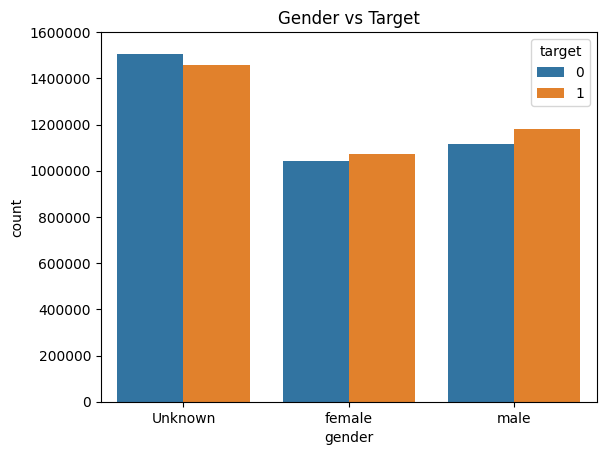

In [20]:
sns.countplot(x="gender", hue="target", data=df_train)
plt.title('Gender vs Target')

locs, labels = plt.yticks()
new_labels = ['{:.0f}'.format(val) for val in locs]
plt.yticks(locs, new_labels)

plt.show()

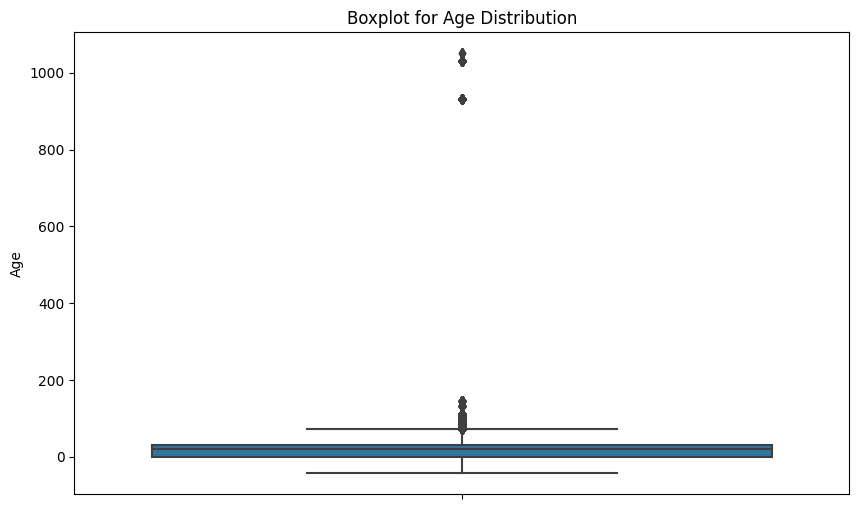

In [22]:
# Plotting the boxplot for age
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_train['bd'])
plt.title('Boxplot for Age Distribution')
plt.ylabel('Age')
plt.show()

As the column age has a lot of outlier, we change the values of the user age below 16 and above 100 with the median

In [23]:
df_train['bd'].loc[(df_train['bd'] < 16) | (df_train['bd']>=100)] = np.nan

In [24]:
df_train['bd'] = df_train['bd'].fillna(df_train['bd'].median())

<Axes: xlabel='bd', ylabel='Density'>

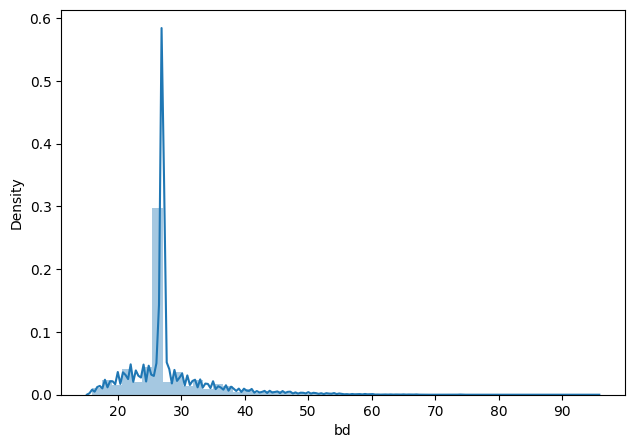

In [25]:
#distribution of the user age
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_train['bd'])

#### SAVE DATA FOR FINAL TRAINING

In [26]:
#note - training_final the same
df_train.to_csv(PATH + 'training_data.csv',index=False)

#### DELVE INTO EDA

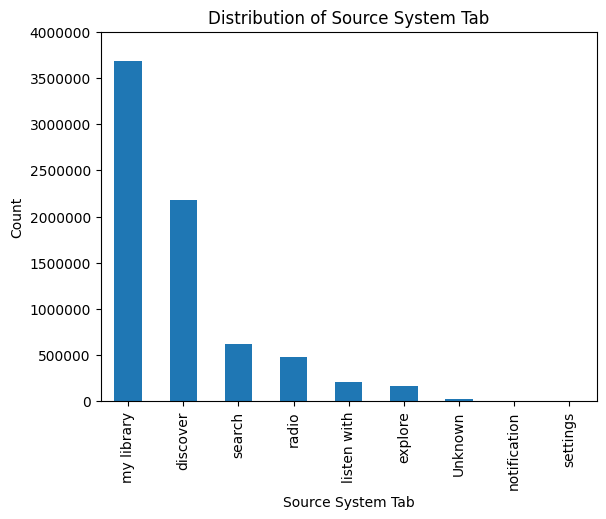

In [ ]:
#Distribution of source_system_tab
df_train['source_system_tab'].value_counts().plot(kind='bar')
plt.title('Distribution of Source System Tab')
plt.xlabel('Source System Tab')
plt.ylabel('Count')

locs, labels = plt.yticks()
new_labels = ['{:.0f}'.format(val) for val in locs]
plt.yticks(locs, new_labels)

plt.show()

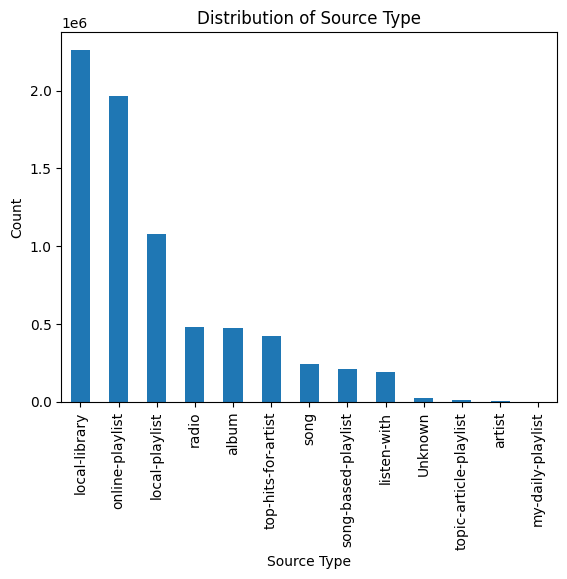

In [ ]:
df_train['source_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Source Type')
plt.xlabel('Source Type')
plt.ylabel('Count')
plt.show()

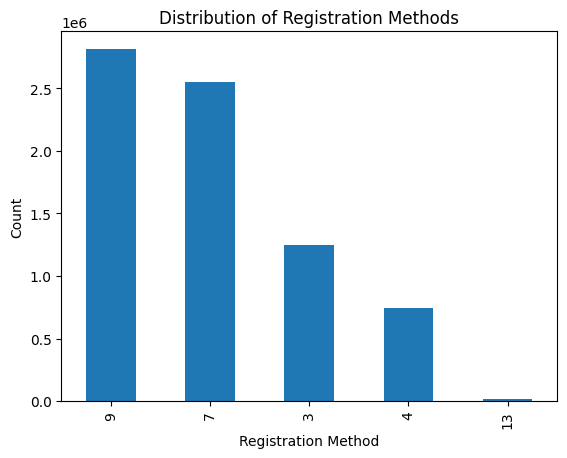

In [ ]:
#Registration methods
df_train['registered_via'].value_counts().plot(kind='bar')
plt.title('Distribution of Registration Methods')
plt.xlabel('Registration Method')
plt.ylabel('Count')
plt.show()

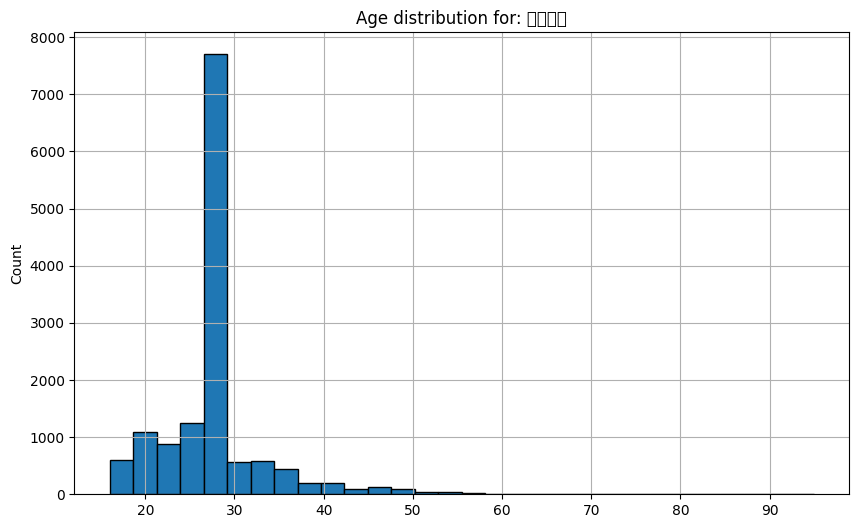

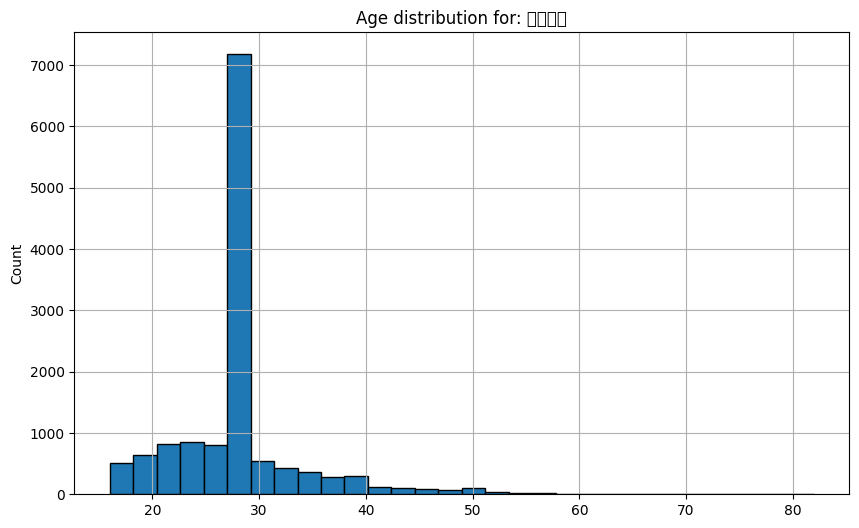

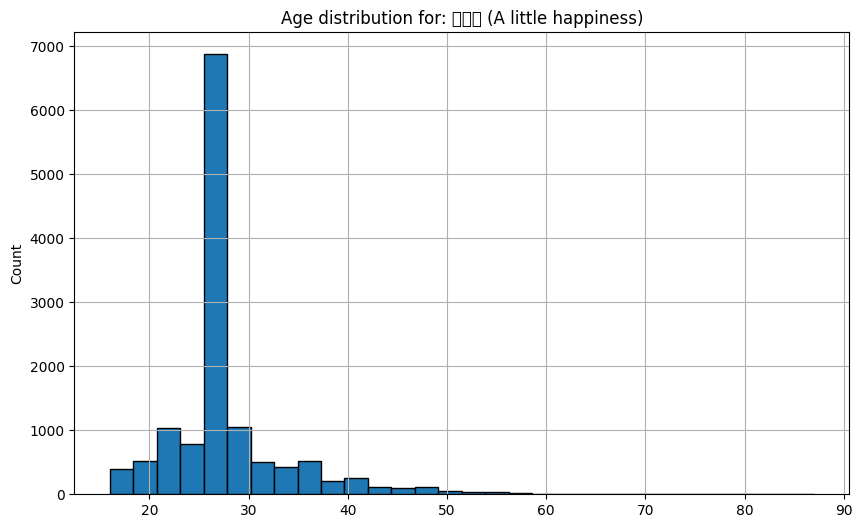

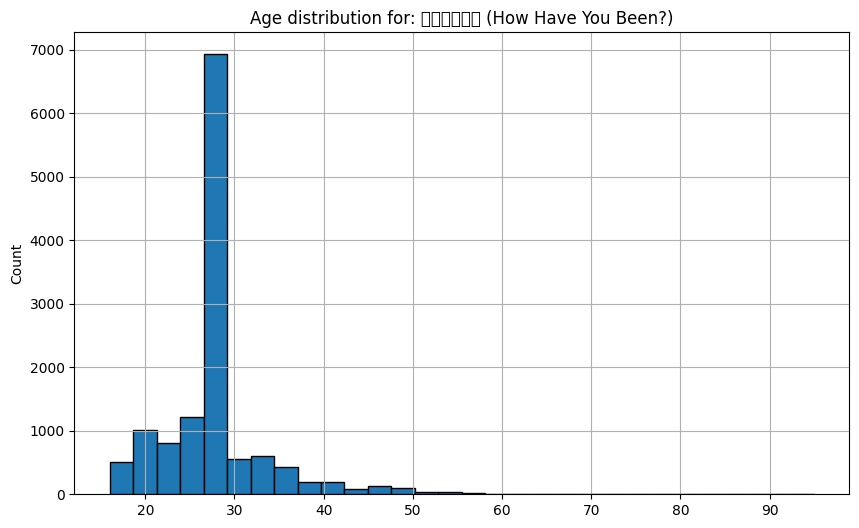

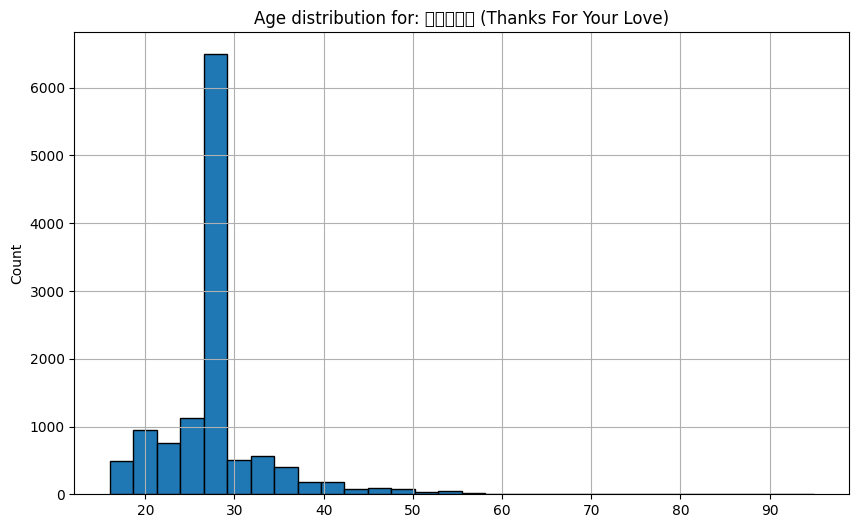

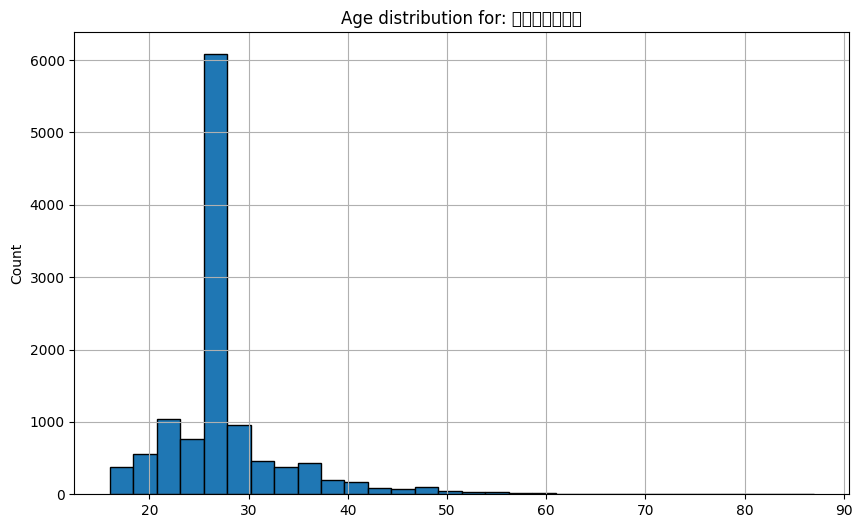

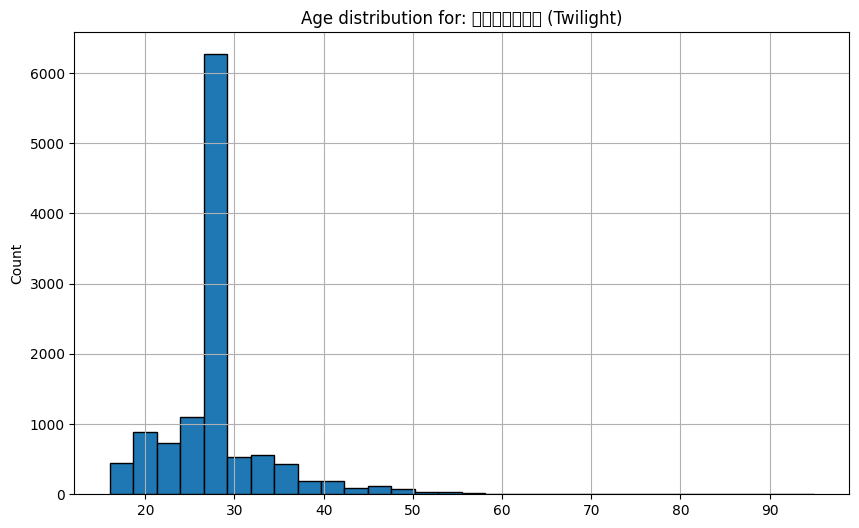

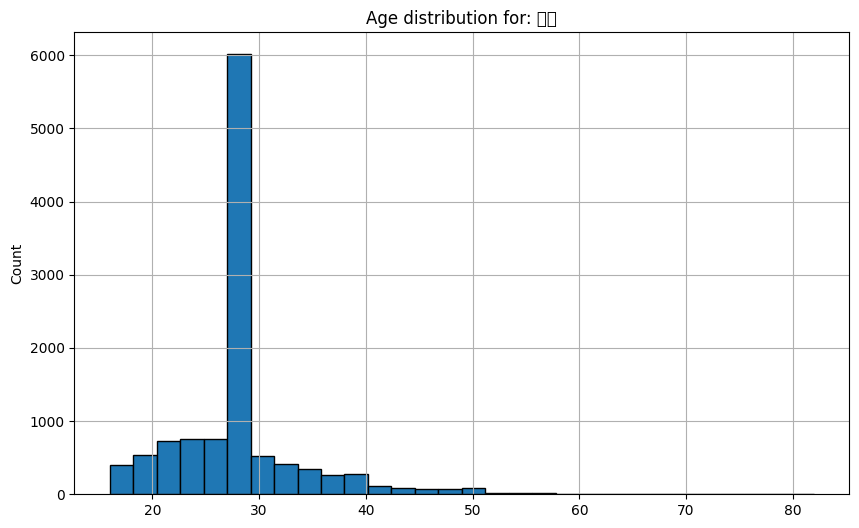

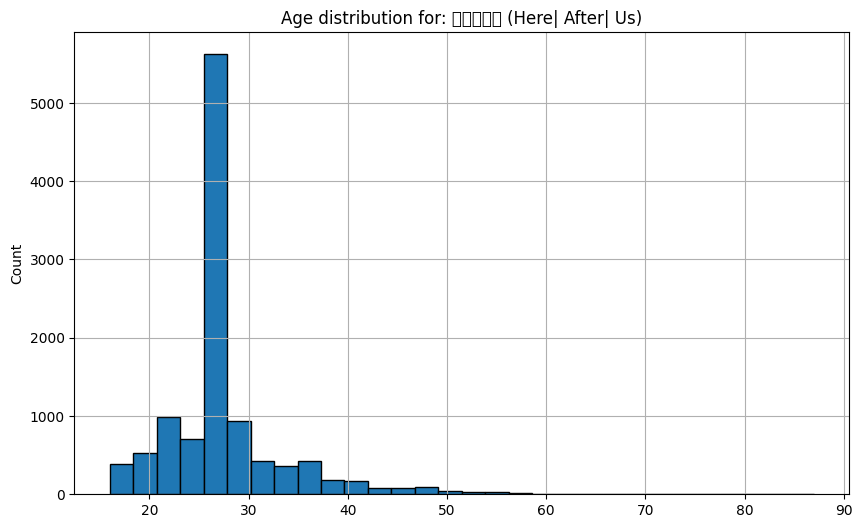

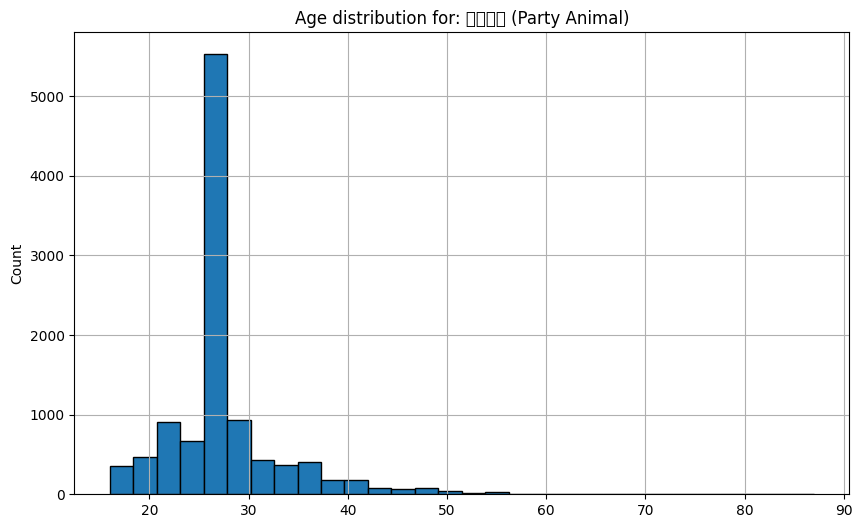

In [29]:
#user age distribution for the top listened songs
top_10_songs = df_train['song_id'].value_counts().head(10).index.tolist()
top_songs_users = df_train[df_train['song_id'].isin(top_10_songs)]

for song in top_10_songs:
    plt.figure(figsize=(10, 6))
    top_songs_users[top_songs_users['song_id'] == song]['bd'].hist(bins=30, edgecolor='black')

    song_name = df_song_extra_info[df_song_extra_info['song_id'] == song]['name'].iloc[0]

    plt.title(f"Age distribution for: {song_name}")
    plt.ylabel('Count')
    plt.show()

In [25]:
#top 10 artists
top_10_artists = df_train['artist_name'].value_counts().head(10)
print("Top 10 Artists:\n", top_10_artists)

Top 10 Artists:
 Various Artists     303616
周杰倫 (Jay Chou)      186776
五月天 (Mayday)        182088
林俊傑 (JJ Lin)        115325
田馥甄 (Hebe)          104946
aMEI (張惠妹)           82799
陳奕迅 (Eason Chan)     76035
玖壹壹                  70445
G.E.M.鄧紫棋            67296
BIGBANG              61927
Name: artist_name, dtype: int64


In [26]:
#top 10 composers
top_10_composers = df_train['composer'].value_counts().head(10)
print("Top 10 Compositors:\n", top_10_composers)

Top 10 Compositors:
 Unknown      1676106
周杰倫           201910
阿信             90343
林俊傑            78606
陳皓宇            58837
JJ Lin         48089
張簡君偉           43619
Eric Chou      42832
韋禮安            39621
八三夭 阿璞         32782
Name: composer, dtype: int64


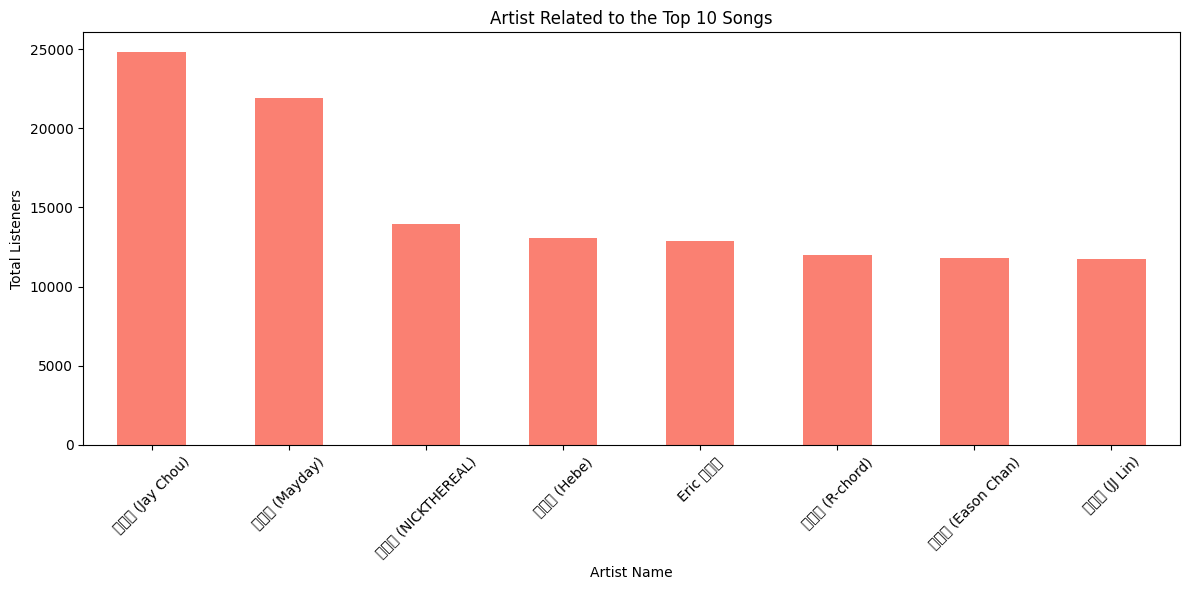

In [28]:
# Getting the data for top 10 songs with artist info
top_10_songs_artist_data = df_train[df_train['song_id'].isin(top_10_songs)][['song_id', 'artist_name']]

# Splitting the 'artist' column
top_10_songs_artist_data = (top_10_songs_artist_data.set_index(['song_id'])
                              .apply(lambda x: x.str.split('|').explode())
                              .reset_index())

# Counting how many times each artist is associated with the top 10 songs
artist_song_counts = top_10_songs_artist_data['artist_name'].value_counts()

# Plotting the composers related to the top 10 songs
plt.figure(figsize=(12, 6))
artist_song_counts.head(10).plot(kind='bar', color='salmon')  # Display top 10 composers if there are more
plt.title('Artist Related to the Top 10 Songs')
plt.xlabel('Artist Name')
plt.ylabel('Total Listeners')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

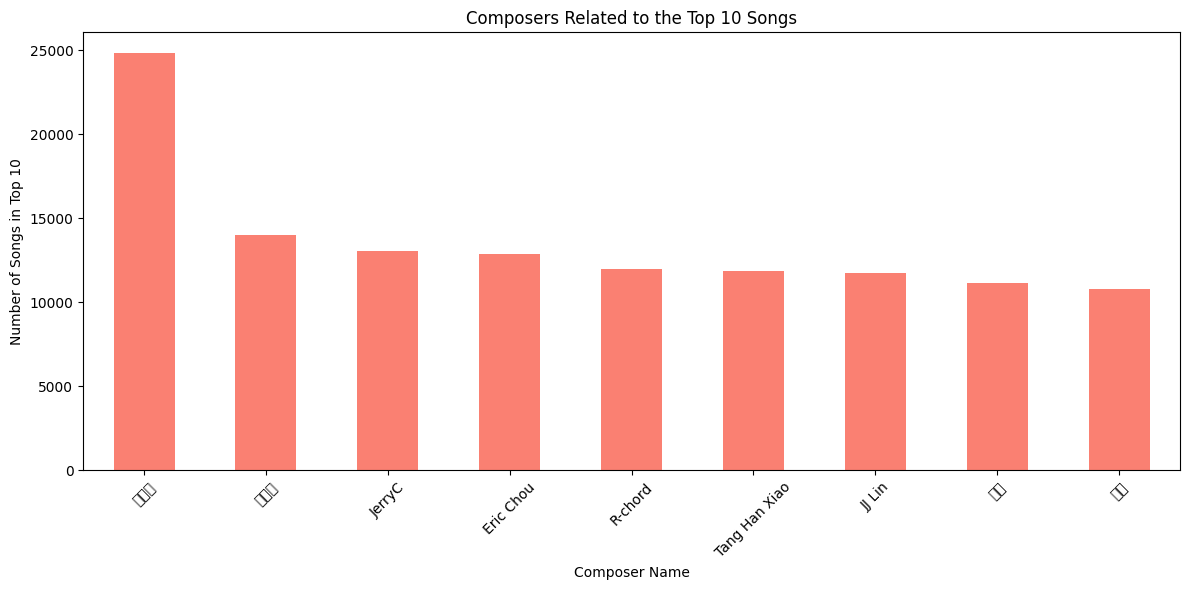

In [29]:
# Get the data for top 10 songs with composer info
top_10_songs_composer_data = df_train[df_train['song_id'].isin(top_10_songs)][['song_id', 'composer']]

# Splitting the 'composer' column
top_10_songs_composer_data = (top_10_songs_composer_data.set_index(['song_id'])
                              .apply(lambda x: x.str.split('|').explode())
                              .reset_index())

# Counting how many songs from the top 10 each composer has
composer_song_counts = top_10_songs_composer_data['composer'].value_counts()

# Plotting the composers related to the top 10 songs
plt.figure(figsize=(12, 6))
composer_song_counts.head(10).plot(kind='bar', color='salmon')  # Display top 10 composers if there are more
plt.title('Composers Related to the Top 10 Songs')
plt.xlabel('Composer Name')
plt.ylabel('Number of Songs in Top 10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Average song length for popular songs: 245120.9110490237
Standard Deviation song length for popular songs: 67344.21448174989

Overall average song length: 245120.9110490237
Overall standard deviation song length: 67344.21448174989


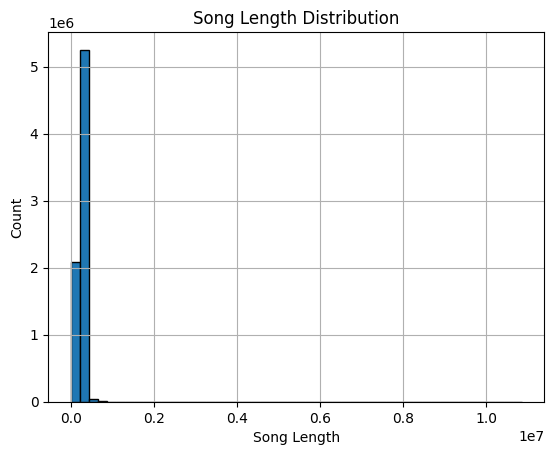

In [35]:
# Getting mean and standard deviation of song length for popular songs
popular_song_length = df_train['song_length'].mean()
popular_song_length_std = df_train['song_length'].std()
# Comparing it with overall mean
overall_song_length = df_train['song_length'].mean()
overall_song_length_std = df_train['song_length'].std()

print(f"Average song length: {popular_song_length}")
print(f"Standard Deviation song length: {popular_song_length_std}")
print("")
print(f"Overall average song length: {overall_song_length}")
print(f"Overall standard deviation song length: {overall_song_length_std}")

# Song Length Distribution:
df_train['song_length'].hist(bins=50, edgecolor='black')
plt.title("Song Length Distribution")
plt.xlabel("Song Length")
plt.ylabel("Count")
plt.show()

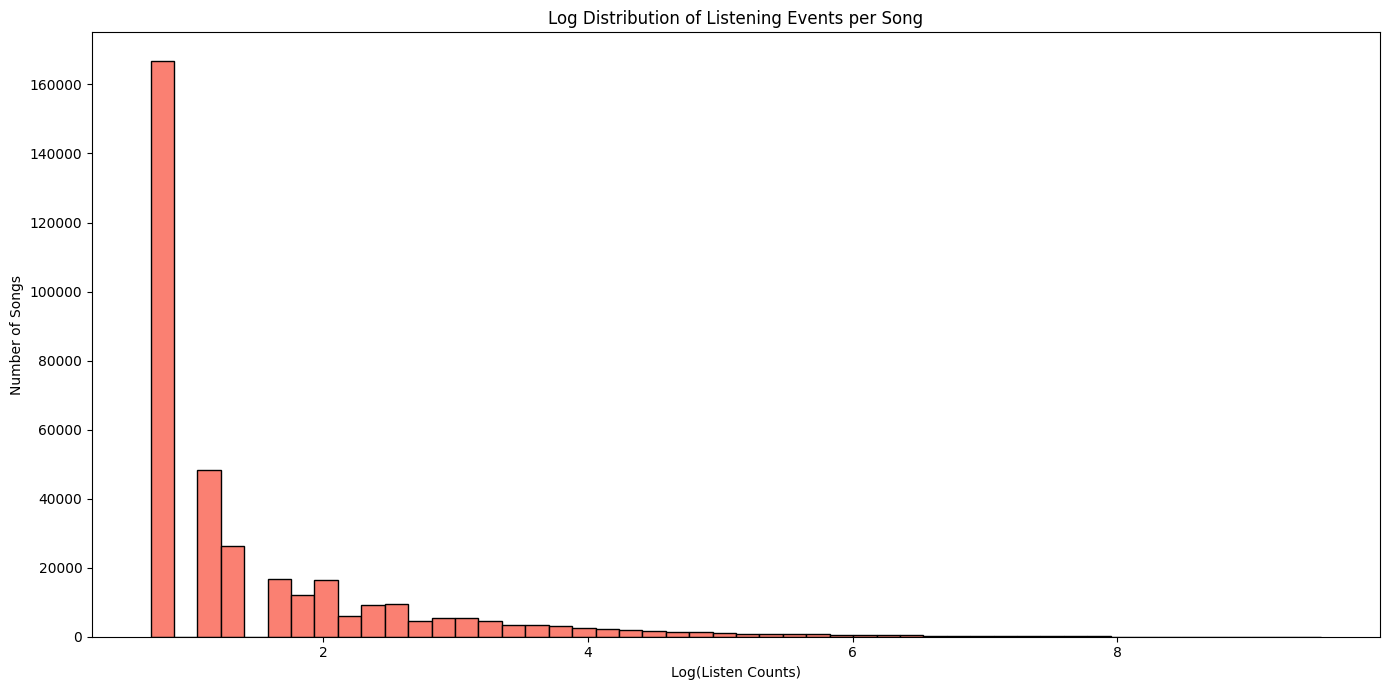

In [32]:
import numpy as np
import matplotlib.pyplot as plt

song_listen_counts = df_train['song_id'].value_counts()

plt.figure(figsize=(14, 7))

# Plotting the histogram on a log scale
plt.hist(np.log1p(song_listen_counts), bins=50, color='salmon', edgecolor='black')

plt.title('Log Distribution of Listening Events per Song')
plt.xlabel('Log(Listen Counts)')
plt.ylabel('Number of Songs')
plt.tight_layout()
plt.show()

A lot of songs have been listened to very few number of times. Thus, the songs which are listened to many times might be very popular ones.

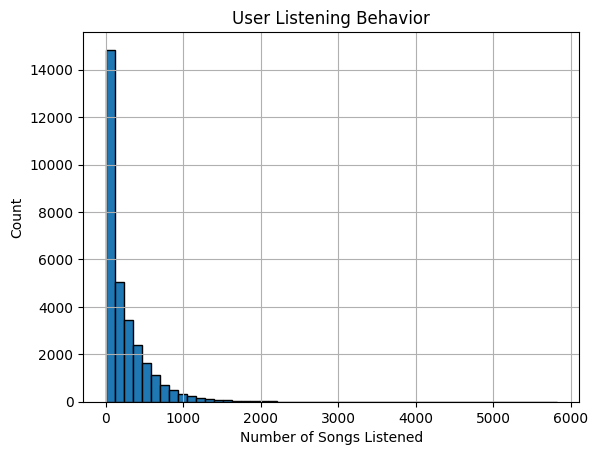

In [33]:
# User Listening Behavior:
user_song_count = df_train.groupby('msno').size()
user_song_count.hist(bins=50, edgecolor='black')
plt.title("User Listening Behavior")
plt.xlabel("Number of Songs Listened")
plt.ylabel("Count")
plt.show()

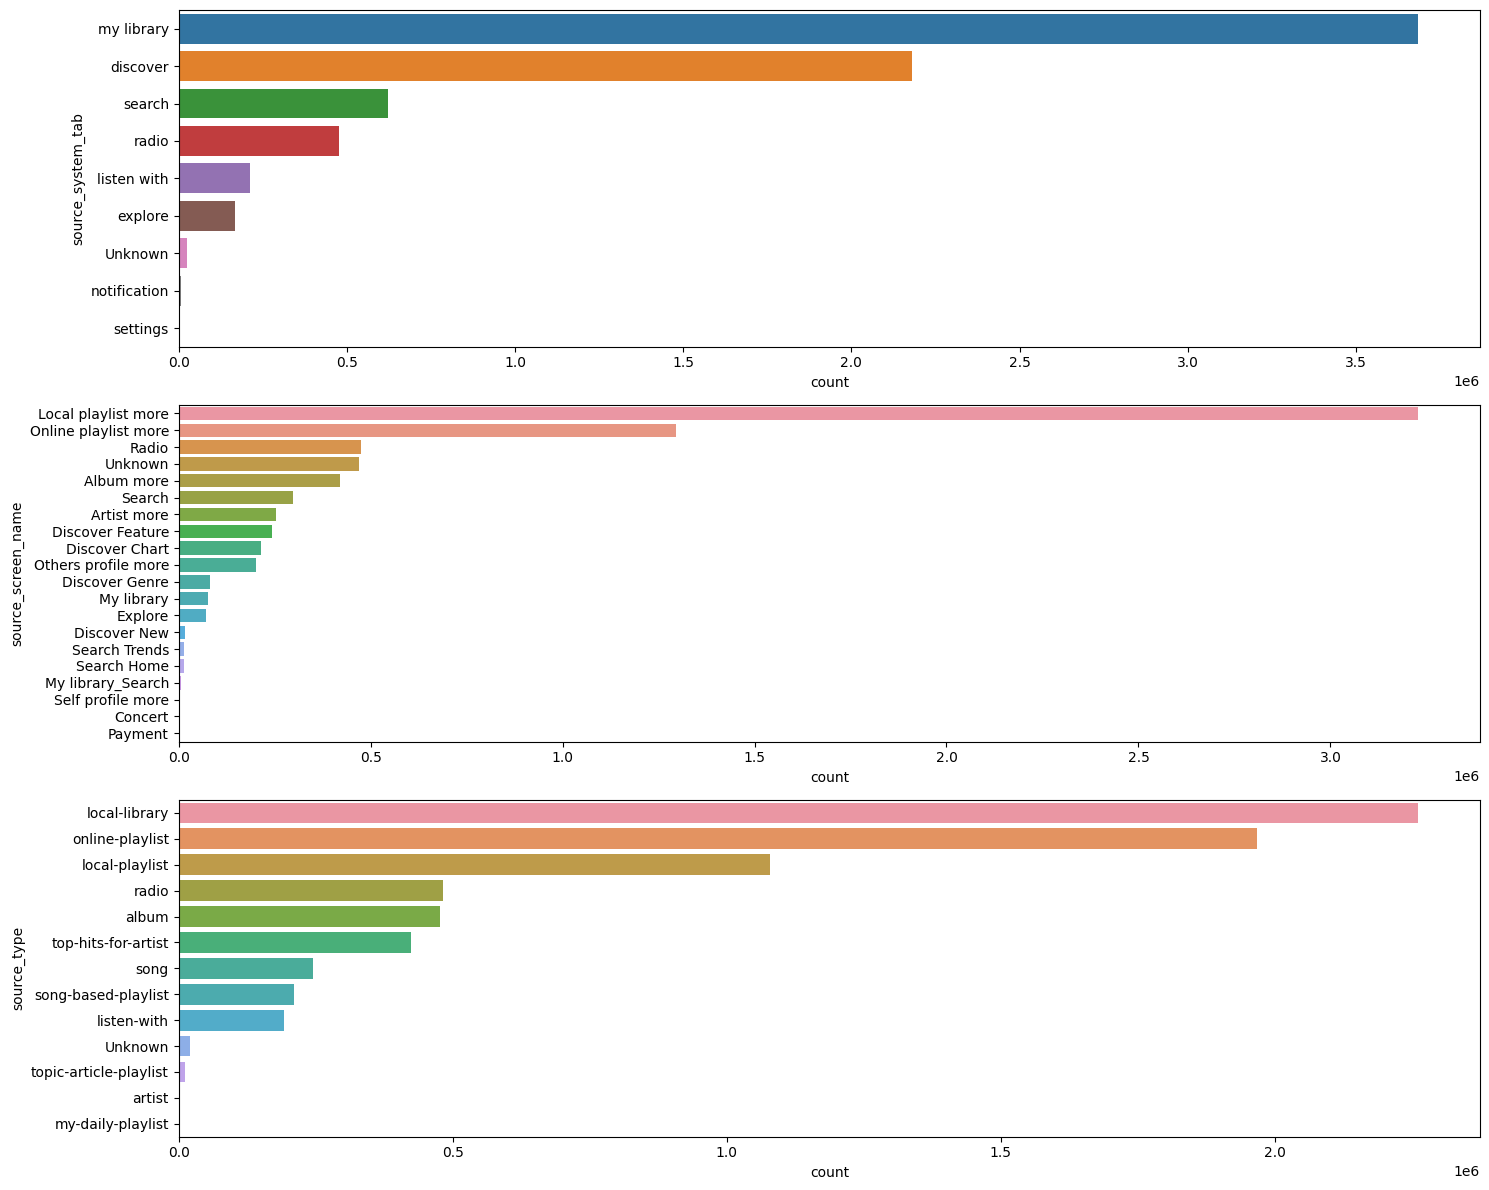

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
sns.countplot(data=df_train, y='source_system_tab', ax=ax[0], order = df_train['source_system_tab'].value_counts().index)
sns.countplot(data=df_train, y='source_screen_name', ax=ax[1], order = df_train['source_screen_name'].value_counts().index)
sns.countplot(data=df_train, y='source_type', ax=ax[2], order = df_train['source_type'].value_counts().index)
plt.tight_layout()
plt.show()

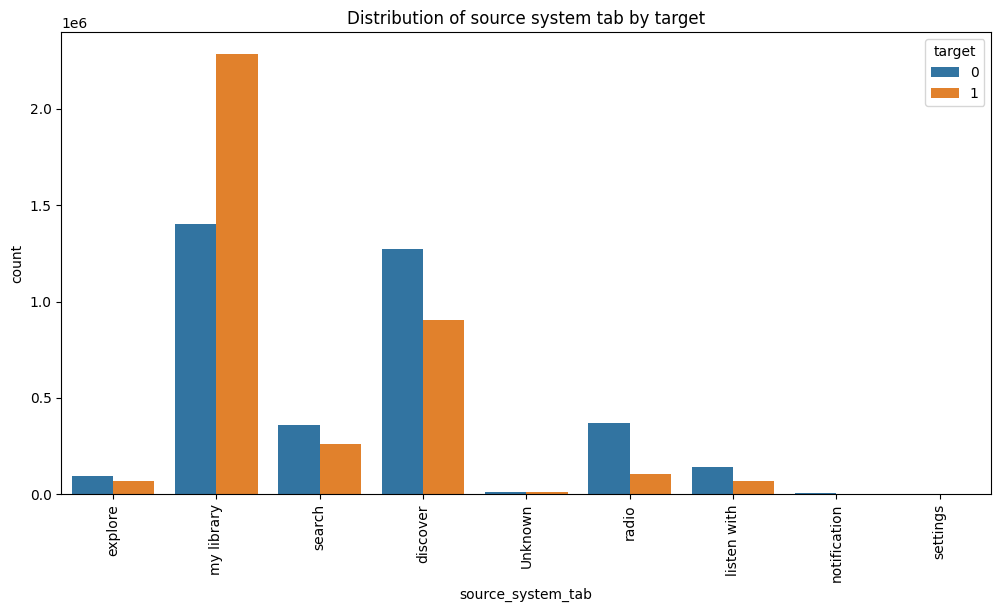

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, x='source_system_tab', hue='target')
plt.title("Distribution of source system tab by target")
plt.xticks(rotation=90)
plt.show()

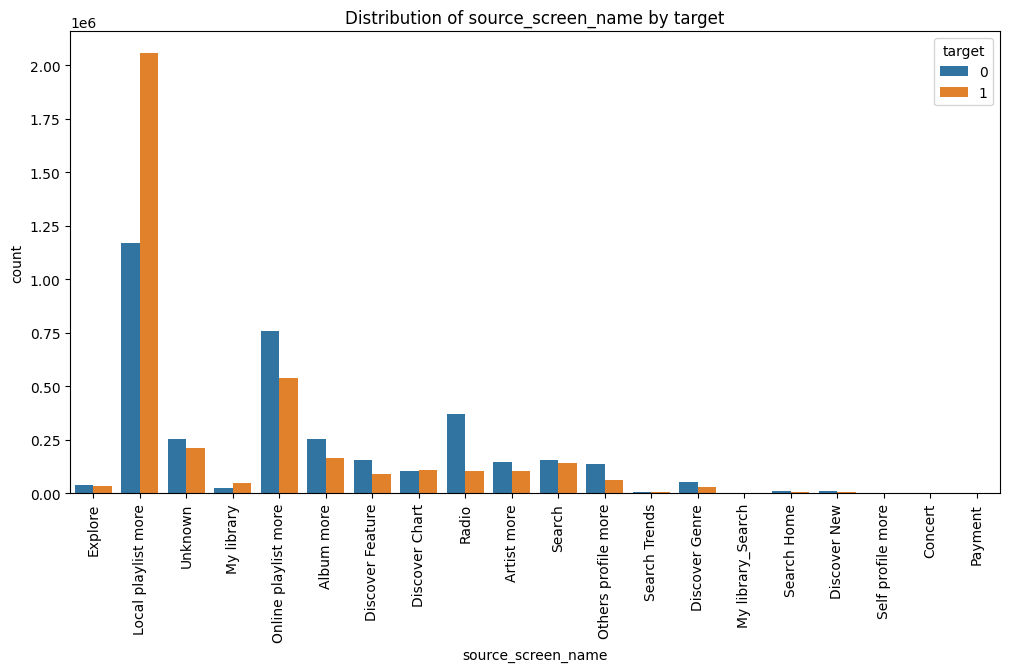

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, x='source_screen_name', hue='target')
plt.title("Distribution of source_screen_name by target")
plt.xticks(rotation=90)
plt.show()

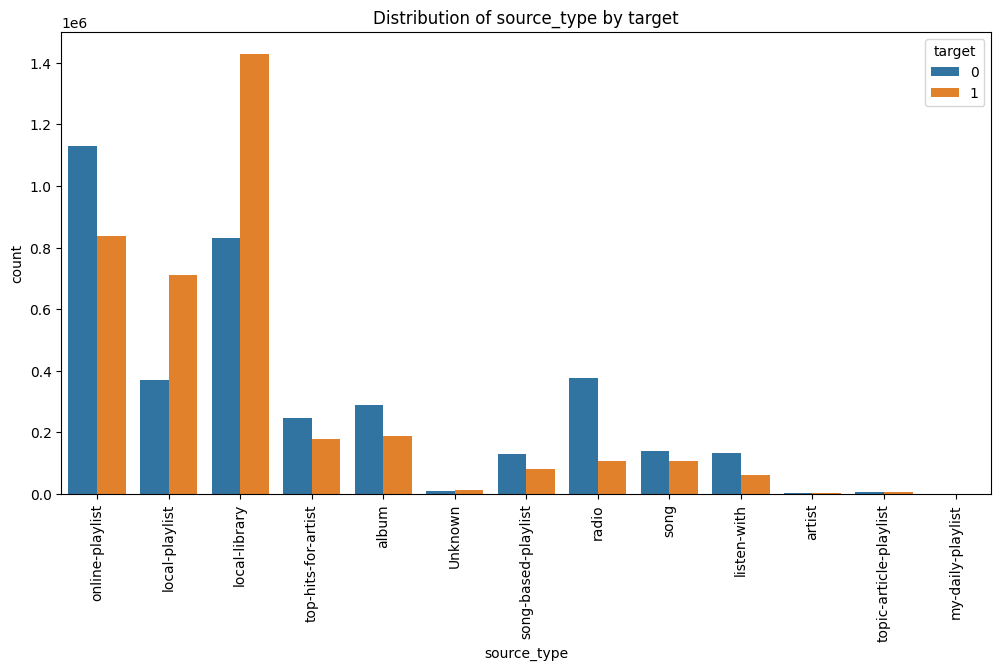

In [37]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, x='source_type', hue='target')
plt.title("Distribution of source_type by target")
plt.xticks(rotation=90)
plt.show()

Analysis on genres

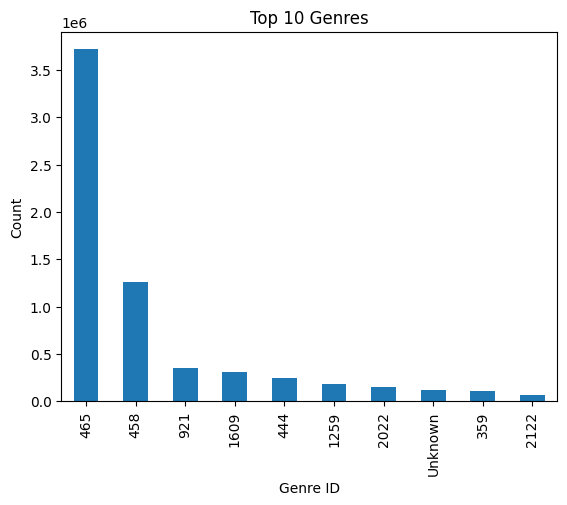

In [37]:
top_genres = df_train['genre_ids'].value_counts().head(10)
top_genres.plot(kind='bar')
plt.title('Top 10 Genres')
plt.xlabel('Genre ID')
plt.ylabel('Count')
plt.show()

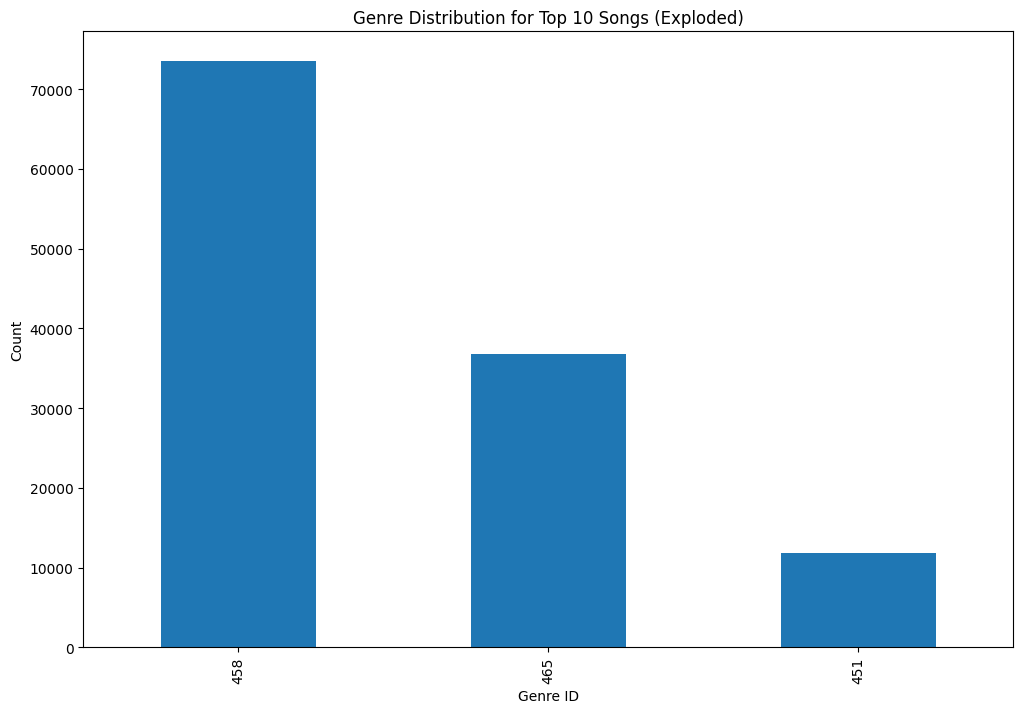

Popular genres that are associated with top 10 songs (Exploded):
465    3848078
458    1311333
Name: split_genres, dtype: int64


In [30]:
# Splitting the genre_ids by '|' and then using explode to get individual genres for each song
df_temp = df_train.copy()
df_temp['split_genres'] = df_temp['genre_ids'].str.split('|')
df_genres_exploded = df_temp.explode('split_genres')

# For the top 10 songs
top_10_songs_genres_exploded = df_genres_exploded[df_genres_exploded['song_id'].isin(top_10_songs)]

plt.figure(figsize=(12, 8))
top_10_songs_genres_exploded['split_genres'].value_counts().plot(kind='bar')
plt.title('Genre Distribution for Top 10 Songs (Exploded)')
plt.xlabel('Genre ID')
plt.ylabel('Count')
plt.show()

# Most popular genres in the dataset (exploded)
top_genres_all_exploded = df_genres_exploded['split_genres'].value_counts().head(10)

# Check which of the top genres are also associated with the top 10 songs
common_genres_exploded = top_genres_all_exploded[top_genres_all_exploded.index.isin(top_10_songs_genres_exploded['split_genres'])]

print("Popular genres that are associated with top 10 songs (Exploded):")
print(common_genres_exploded)

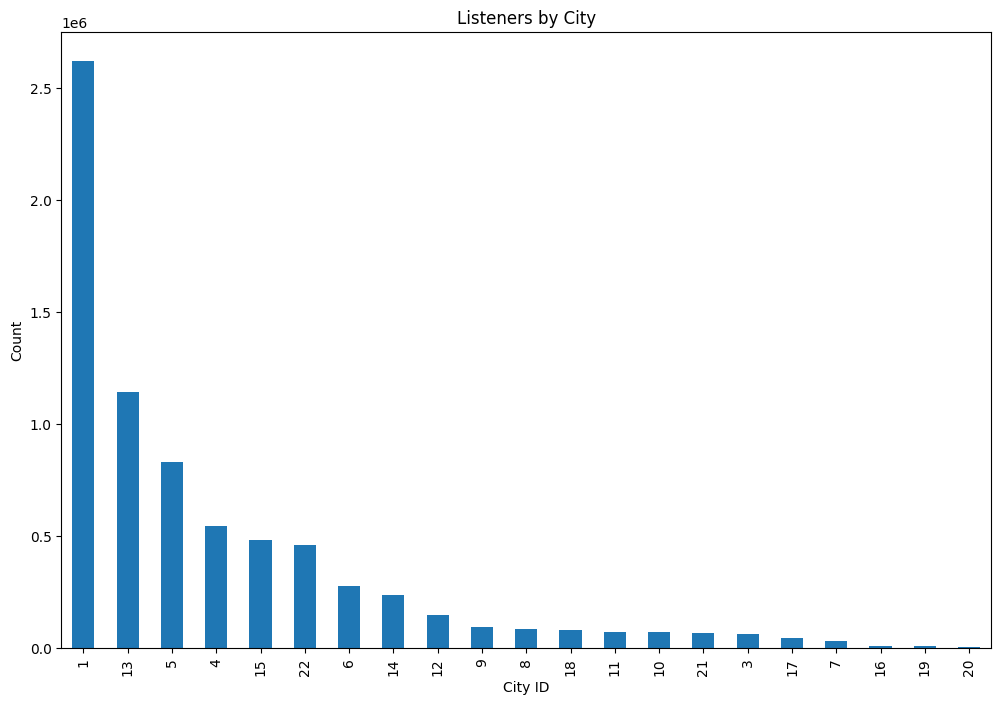

In [31]:
# City-wise active listeners
city_counts = df_train['city'].value_counts()

plt.figure(figsize=(12, 8))
city_counts.plot(kind='bar')
plt.title('Listeners by City')
plt.xlabel('City ID')
plt.ylabel('Count')
plt.show()

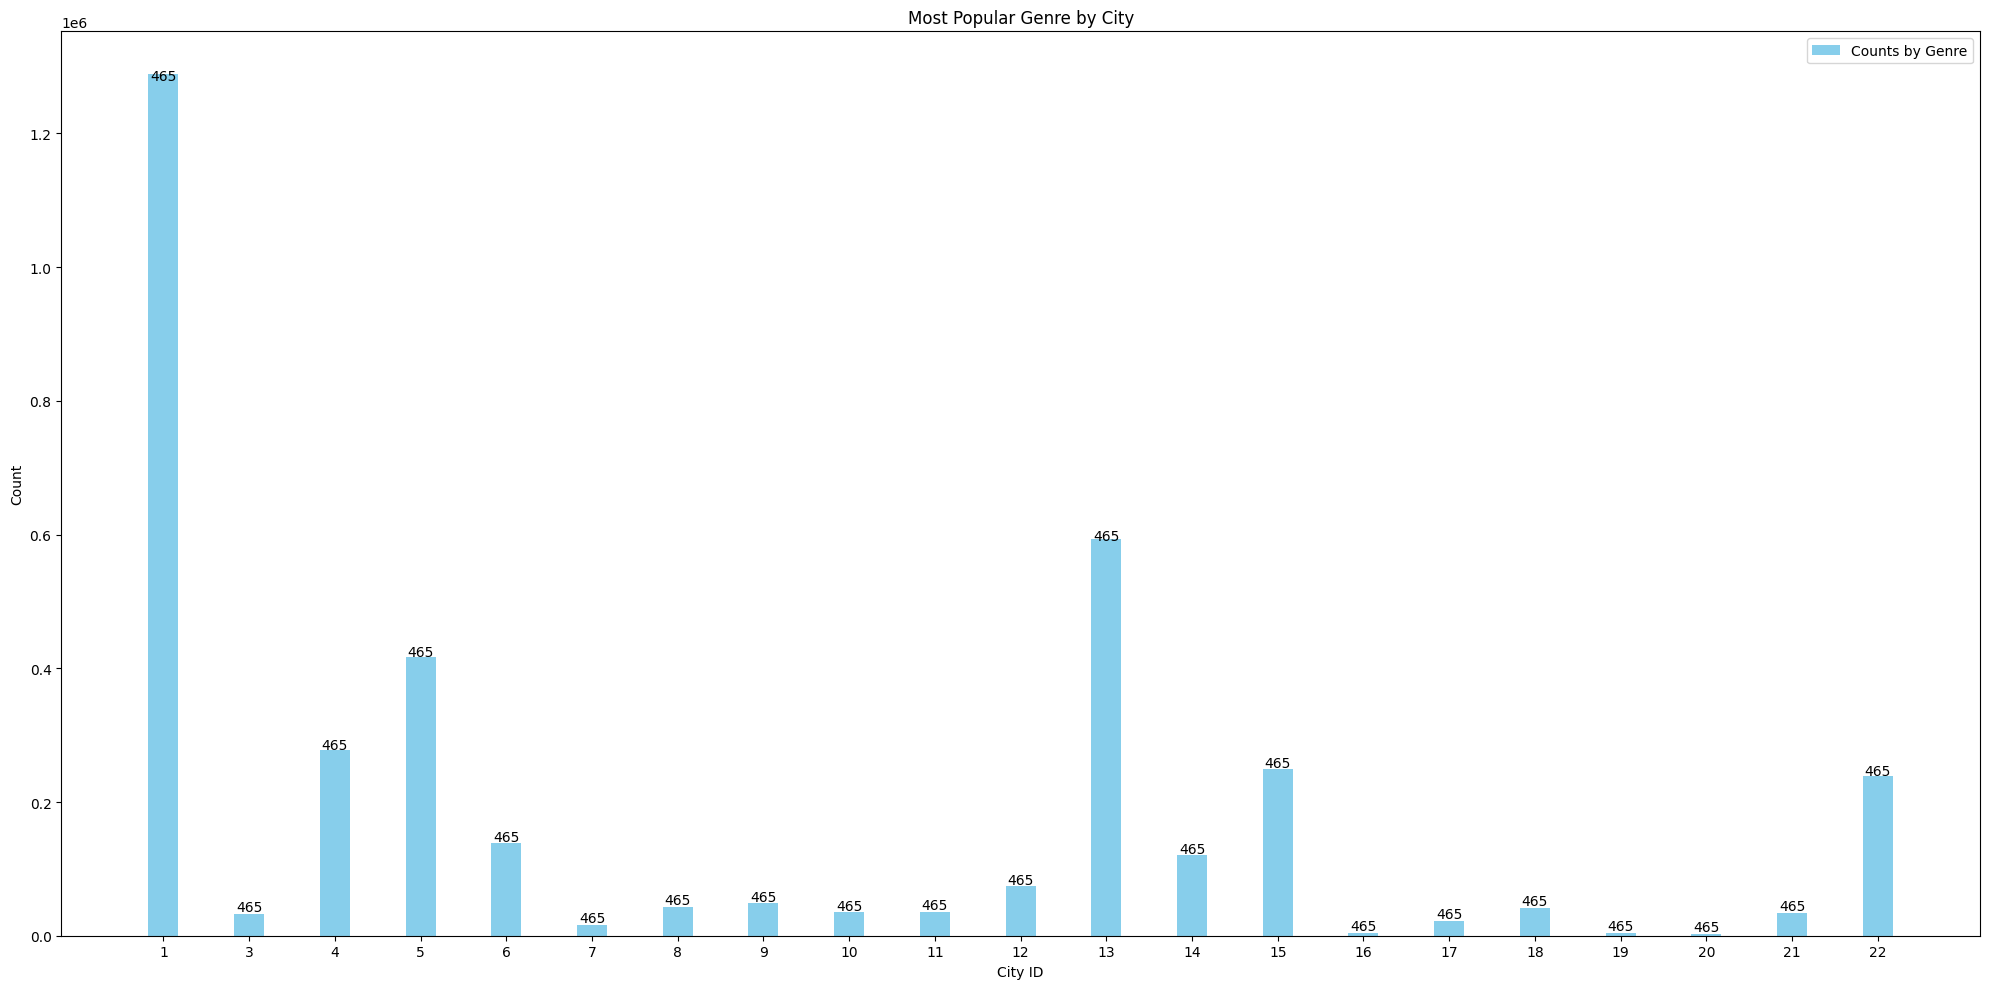

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Grouping by city and genre_ids and counting the occurrences
city_genre_counts = df_train.groupby(['city', 'genre_ids']).size().reset_index(name='counts')

# For each city, find the genre with the maximum count
top_genre_per_city = city_genre_counts.loc[city_genre_counts.groupby('city')['counts'].idxmax()]

# Plotting
plt.figure(figsize=(20, 10))
bar_width = 0.35
city_ids = sorted(df_train['city'].unique())
indices = np.arange(len(city_ids))

# Extract counts for each city
counts = [top_genre_per_city[top_genre_per_city['city'] == city]['counts'].values[0] if city in top_genre_per_city['city'].values else 0 for city in city_ids]

# Extract genres for each city
genres = [top_genre_per_city[top_genre_per_city['city'] == city]['genre_ids'].values[0] if city in top_genre_per_city['city'].values else 'N/A' for city in city_ids]

bars = plt.bar(indices, counts, bar_width, label='Counts by Genre', color='skyblue')

# Label with genre ids
for i, rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 0.99*height,
             genres[i], ha='center', va='bottom')

plt.xlabel('City ID')
plt.ylabel('Count')
plt.title('Most Popular Genre by City')
plt.xticks(indices, city_ids)
plt.legend()
plt.tight_layout()
plt.show()

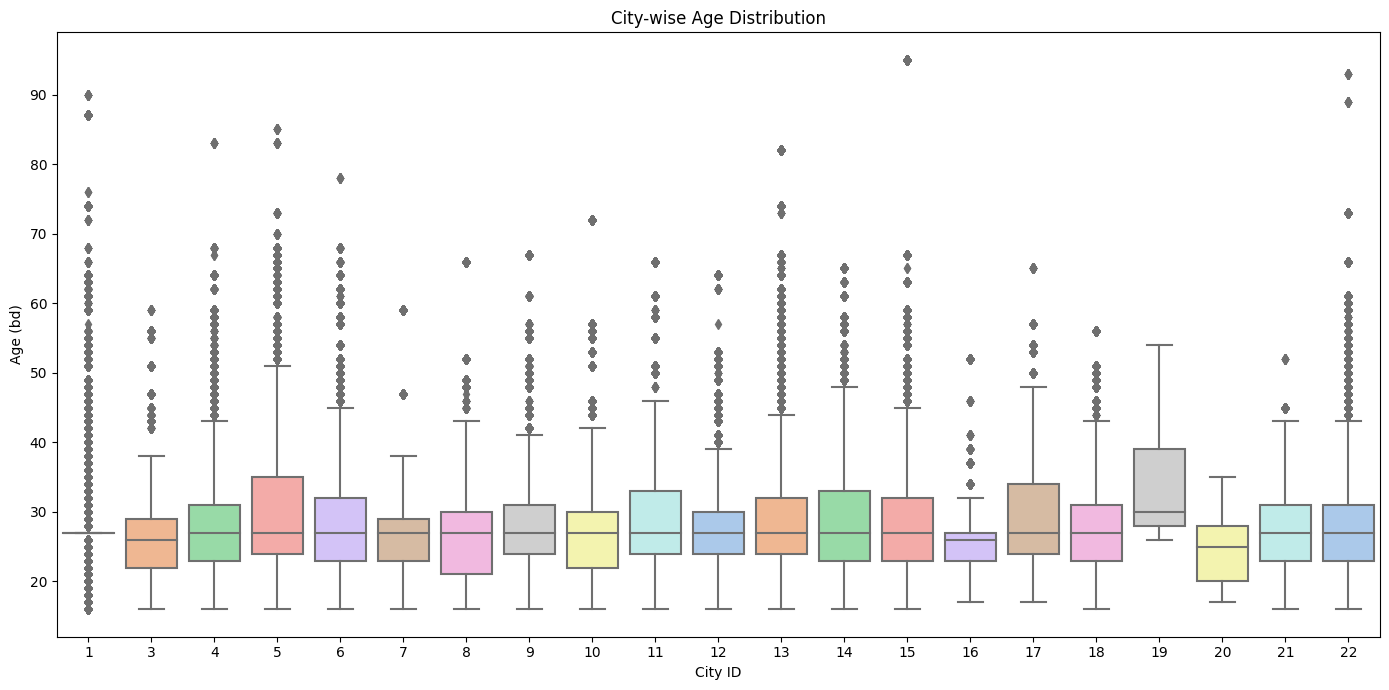

In [33]:
#city age distribution
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_train, x='city', y='bd', palette="pastel")
plt.title('City-wise Age Distribution')
plt.xlabel('City ID')
plt.ylabel('Age (bd)')
plt.tight_layout()
plt.show()

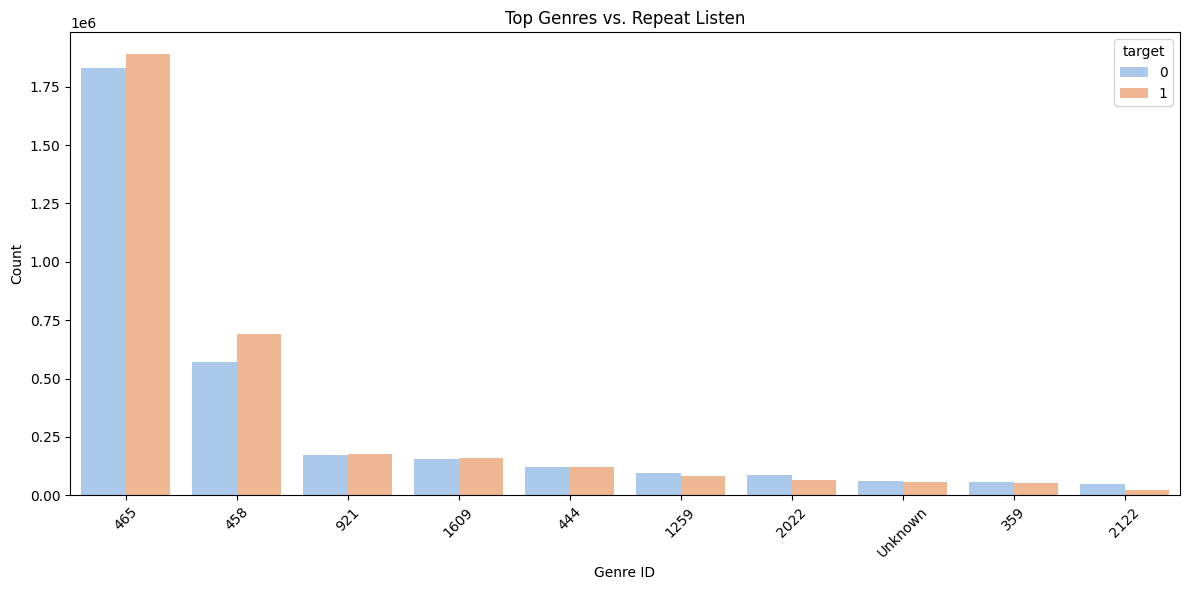

In [34]:
top_genres = df_train['genre_ids'].value_counts().head(10).index.tolist()
df_top_genres = df_train[df_train['genre_ids'].isin(top_genres)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_top_genres, x='genre_ids', hue='target', palette='pastel', order=df_top_genres['genre_ids'].value_counts().index)
plt.title('Top Genres vs. Repeat Listen')
plt.xlabel('Genre ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
df_date_format = df_train.copy()

#Convert registration and expiration date into a more readable format
df_date_format['registration_init_time'] = pd.to_datetime(df_date_format["registration_init_time"], format="%Y%m%d")

# Extract year, month and day for registration date
df_date_format['registration_year'] = df_date_format['registration_init_time'].dt.year
df_date_format['registration_month'] = df_date_format['registration_init_time'].dt.month
df_date_format['registration_day'] = df_date_format['registration_init_time'].dt.day

# Extract year, month and day for expiration date
df_date_format['expiration_date'] = pd.to_datetime(df_train['expiration_date'], format='%Y%m%d')

df_date_format['expiration_year'] = df_date_format['expiration_date'].dt.year
df_date_format['expiration_month'] = df_date_format['expiration_date'].dt.month
df_date_format['expiration_day'] = df_date_format['expiration_date'].dt.day

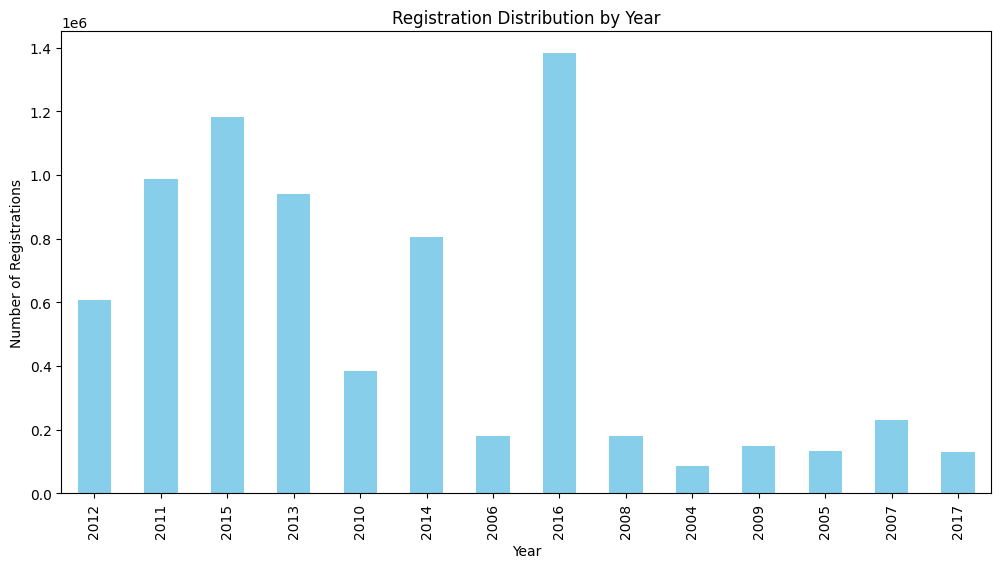

In [36]:
import matplotlib.pyplot as plt

# Plotting the distribution
plt.figure(figsize=(12, 6))
df_date_format['registration_year'].value_counts(sort=False).plot(kind='bar', color='skyblue')
plt.title('Registration Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Registrations')
plt.show()

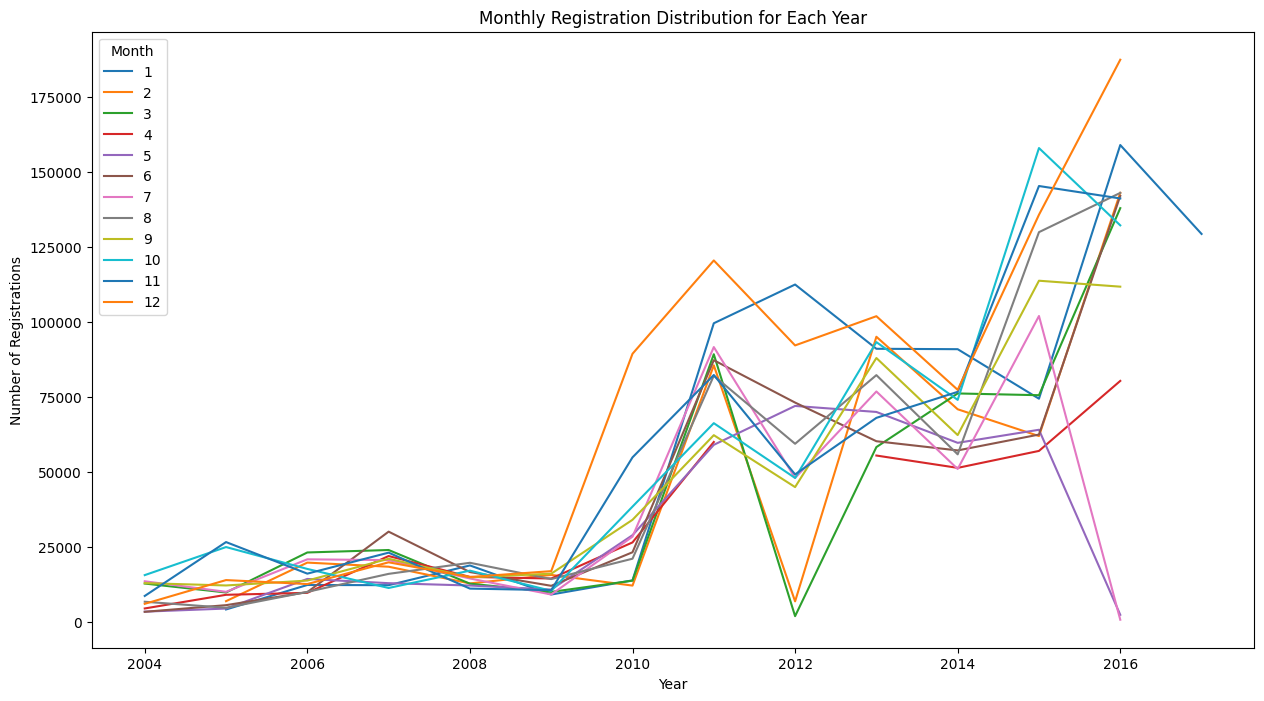

In [37]:
# Group by year and month and count the registrations
monthly_registrations = df_date_format.groupby(['registration_year', 'registration_month']).size().unstack()

# Plotting the monthly registration distribution
plt.figure(figsize=(15, 8))
monthly_registrations.plot(ax=plt.gca())
plt.title('Monthly Registration Distribution for Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Registrations')
plt.legend(title='Month', loc='upper left')
plt.show()

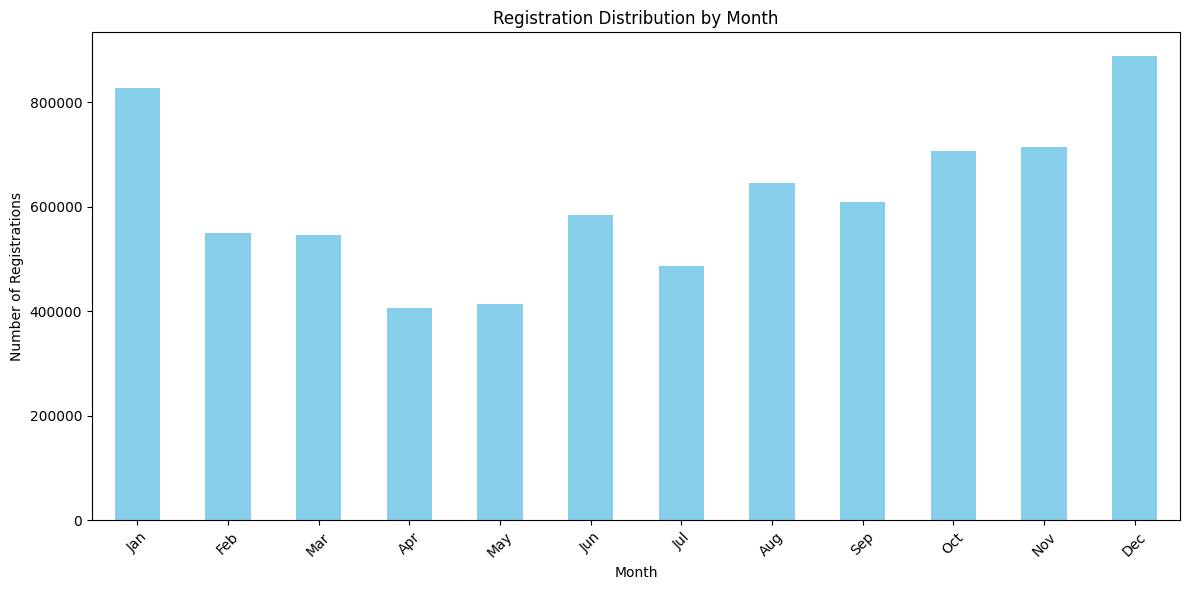

In [38]:
# Plotting the distribution by month
plt.figure(figsize=(12, 6))
df_date_format['registration_month'].value_counts(sort=False).sort_index().plot(kind='bar', color='skyblue')
plt.title('Registration Distribution by Month')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.ylabel('Number of Registrations')
plt.tight_layout()
plt.show()

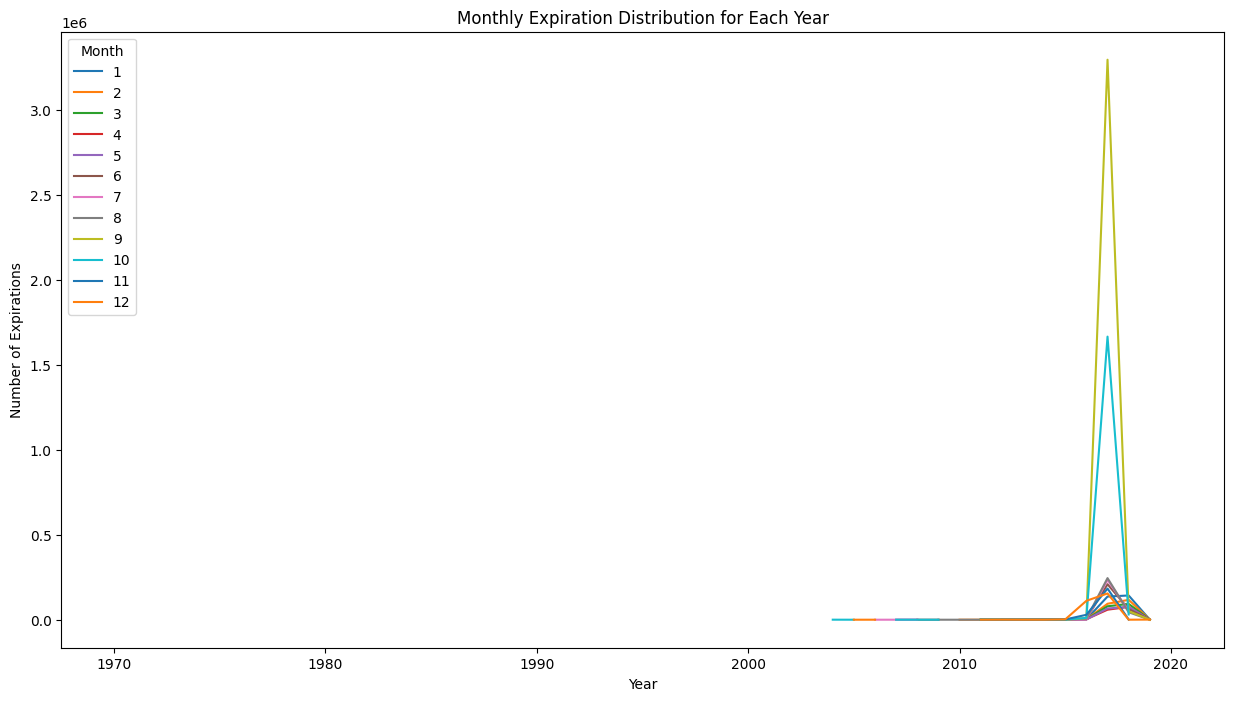

In [41]:
# Group by year and month and count the registrations
monthly_expirations = df_date_format.groupby(['expiration_year', 'expiration_month']).size().unstack()

# Plotting the monthly registration distribution
plt.figure(figsize=(15, 8))
monthly_expirations.plot(ax=plt.gca())
plt.title('Monthly Expiration Distribution for Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Expirations')
plt.legend(title='Month', loc='upper left')
plt.show()

#### SAVE THE DATA FOR THE MODELS

In [ ]:
#df_train.to_csv(PATH + 'training_final.csv',index=False)

# Cleaned Data for the Models

In [40]:
PATH = '/content/drive/My Drive/music_recommendation/data/'
df = pd.read_csv(PATH + 'training_data.csv') #training_final

In [42]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377412 entries, 0 to 7377411
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   song_length             float64
 7   genre_ids               object 
 8   artist_name             object 
 9   composer                object 
 10  lyricist                object 
 11  language                float64
 12  city                    int64  
 13  bd                      float64
 14  gender                  object 
 15  registered_via          int64  
 16  registration_init_time  int64  
 17  expiration_date         int64  
dtypes: float64(3), int64(5), object(10)
memory usage: 1013.1+ MB
None


In [43]:
df = df.drop(['registration_init_time', 'expiration_date'], axis=1)

In [44]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# numerical columns excluding the target
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'target' in numerical_columns:
    numerical_columns.remove('target')

# Feed Forward Neural Network

#### Encoding
* Categorical Data columns were identified and then the labels are encoded to transform non-numerical value into numerical ones.
* Numerical columns (excluding the target) were standardized using Standard Scaler



In [45]:
from sklearn.preprocessing import LabelEncoder

def encoders(df, categorical_columns,  numerical_columns):
    encoders = {}
    #encode categorical column
    print("Encoding the categorical columns...it may take a while")
    for column in categorical_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        encoders[column] = le

    print("Encoding the numerical columns...it may take a while")
    #encode numerical columns
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df, encoders, scaler

df_encoded, encoders, scaler = encoders(df, categorical_columns, numerical_columns)

Encoding the categorical columns...it may take a while
Encoding the numerical columns...it may take a while


In [46]:
def batch_generator(df, batch_size, cat_cols, num_cols, target_col):
    while True:
        # Shuffle the dataset
        df = df.sample(frac=1).reset_index(drop=True)

        for index in range(0, len(df), batch_size):
            batch_data = df[index: index + batch_size]

            X_cat = [batch_data[column].values for column in cat_cols]
            X_num = batch_data[num_cols].values
            y = batch_data[target_col].values

            yield [np.array(val) for val in X_cat] + [X_num], y

In [47]:
# Split the data
t, val = train_test_split(df_encoded, test_size=0.2, random_state=42)

train, test = train_test_split(t, test_size=0.2, random_state=42)

#### **Model Architecture**

Each categorical column has an embedding layer. The embeddings represents each category as a vector in a multi-dimensional space. This allows the neural network to learn the best representation for each category in relation to the target variable. The size of the emebdding was determined based on the unique categories in each categorical column. The embedded output were flattened. For numerical columns we use 128 neuros for the standardized numerical column. The output from the emebedding layers and the dense layer for numerical columns were subsequently concatenated.

Followed by Batch Normalization, the concatenated data passes through multiple Dense layers with activation functions set as ReLU. The model utilizes dropout as a regularization technique to prevent overfitting. The final Dense layer uses a sigmoid activation, making it suitable for a binary classification task.

#### **Training Strategy**:
Data Generator: A custom data generator function was written to feed batches of data into the neural network. It shuffles and sends the data batch-wise, making it memory efficient for large datasets.

Callbacks: Used early stopping to halt training when the validation loss does not improve, thus preventing overfitting. Also used ReduceLROnPlateau to adjust the learning rate when validation loss plateaus.

Training: The model was trained with a batch size of 128 and for up to 15 epochs. The training was performed using both training and validation sets.

The neural network's performance is monitored during the training process using the accuracy. The EarlyStopping callback ensures that the model does not overfit by monitoring the validation loss.

In [48]:
from keras.layers import Dropout, BatchNormalization
from keras.layers import Concatenate

input_models = []
output_embeddings = []

# Create embedding for each categorical column
for categorical_var in categorical_columns:
    cat_emb_name = f"{categorical_var}_Embedding"
    no_of_unique_cat = df_encoded[categorical_var].nunique() #df
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50)
    embedding_size = int(embedding_size)
    vocab = no_of_unique_cat + 1
    input_model = Input(shape=(1,), name=f"Input_{categorical_var}")
    embedding = Embedding(vocab, embedding_size, name=cat_emb_name)(input_model)
    embedding = Flatten()(embedding)
    input_models.append(input_model)
    output_embeddings.append(embedding)

In [49]:
# Create input for numerical columns
input_numeric = Input(shape=(len(numerical_columns),), name="Numeric_Input")
dense_numeric = Dense(256, activation='relu')(input_numeric) #128
output_embeddings.append(dense_numeric)
input_models.append(input_numeric)

# Concatenate everything together
output = Concatenate()(output_embeddings)
output = BatchNormalization()(output)

# I increase the neuron count as the combination of categorical embeddings and the numerical dense layer might introduce more complex interactions that need a wider layer to capture.
# Add Dense layers with dropout
output = Dense(256, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)

output = Dense(128, activation='relu')(output)
output = BatchNormalization()(output)

output = Dense(128, activation='relu')(output)
output = BatchNormalization()(output)

output = Dense(64, activation='relu')(output)
output = Dropout(0.2)(output)
output = BatchNormalization()(output)

# Final output layer
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)

In [50]:
from keras.optimizers import Adam

lr = 0.0005
opt = Adam(learning_rate=lr)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_msno (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Input_song_id (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 Input_source_system_tab (I  [(None, 1)]                  0         []                            
 nputLayer)                                                                                       
                                                                                                  
 Input_source_screen_name (  [(None, 1)]                  0         []                        

In [52]:
batch_size = 128

train_gen = batch_generator(train, batch_size, categorical_columns, numerical_columns, "target")
val_gen = batch_generator(val, batch_size, categorical_columns, numerical_columns, "target")

train_steps = len(train) // batch_size
val_steps = len(val) // batch_size

In [53]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Reduce learning rate when the validation loss plateaus
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)

callbacks = [early_stopping, reduce_on_plateau]

In [56]:
model.fit(train_gen,
          validation_data=val_gen,
          validation_steps=val_steps,
          epochs=15,
          steps_per_epoch=train_steps, callbacks = callbacks)

Epoch 1/15
36887/36887 [==============================] - 590s 16ms/step - loss: 0.5707 - accuracy: 0.7005 - val_loss: 0.5416 - val_accuracy: 0.7236 - lr: 5.0000e-04
Epoch 2/15
36887/36887 [==============================] - 566s 15ms/step - loss: 0.5270 - accuracy: 0.7354 - val_loss: 0.5304 - val_accuracy: 0.7316 - lr: 5.0000e-04
Epoch 3/15
36887/36887 [==============================] - 562s 15ms/step - loss: 0.4948 - accuracy: 0.7579 - val_loss: 0.5339 - val_accuracy: 0.7314 - lr: 5.0000e-04
Epoch 4/15
36886/36887 [============================>.] - ETA: 0s - loss: 0.4699 - accuracy: 0.7731
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
36887/36887 [==============================] - 552s 15ms/step - loss: 0.4699 - accuracy: 0.7731 - val_loss: 0.5382 - val_accuracy: 0.7315 - lr: 5.0000e-04
Epoch 5/15
36887/36887 [==============================] - 552s 15ms/step - loss: 0.4307 - accuracy: 0.7956 - val_loss: 0.5700 - val_accuracy: 0.7260 - lr: 1.0000e-04
Epoc

In [57]:
def batch_predictor(df, cat_cols, num_cols):
    X_cat = [df[column].values for column in cat_cols]
    X_num = df[num_cols].values
    return [np.array(val) for val in X_cat] + [X_num]

test_input = batch_predictor(test, categorical_columns, numerical_columns)

y_pred_probs = model.predict(test_input)

36888/36888 [==============================] - 82s 2ms/step


In [58]:
# Actual target values from test set
y_true = test['target'].values
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.7308


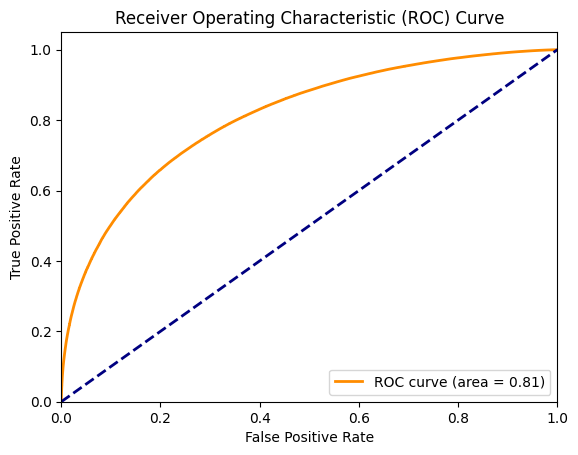

In [59]:
# Compute ROC curve and ROC area (AUC) for predictions
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = roc_auc_score(y_true, y_pred_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# XGBoost

In [60]:
import xgboost as xgb

In [61]:
def encode_cat_features(df, categorical_columns,  numerical_columns):
    encoders = {}
    #encode categorical column
    print("Encoding the categorical columns...it may take a while")
    for column in categorical_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        encoders[column] = le

    return df, encoders

df_encoded_xgb, encoders = encode_cat_features(df, categorical_columns, numerical_columns)

Encoding the categorical columns...it may take a while


In [62]:
X = df_encoded_xgb.drop('target', axis=1)
y = df_encoded_xgb['target']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [ ]:
X_train

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via
6061182,28967,316307,4,18,8,-0.189889,273,26292,31836,32126,-0.737294,-0.980393,-0.159612,0,0.969311
5425599,29632,65422,3,4,6,-0.137917,265,28272,63508,16744,-0.737294,-0.227565,0.288131,2,0.969311
1856764,26805,205711,4,18,8,-0.699584,265,29567,50974,13735,-0.737294,0.826394,-1.502842,2,0.969311
2002148,5263,213593,4,18,7,-0.368761,250,20913,14382,12397,0.584749,-0.227565,-1.204346,1,0.969311
3245556,15857,170160,4,18,7,-0.703266,273,31074,71716,18228,-0.737294,0.525263,-0.607355,2,0.969311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6608218,6830,328198,3,4,6,0.394274,273,28632,62072,15297,-0.737294,-0.980393,-0.159612,0,0.090489
1623640,3181,73292,4,18,7,-0.047932,526,29319,66932,20352,-0.737294,-0.980393,-0.159612,0,0.090489
3691006,10399,219608,1,3,10,-0.116965,273,14602,19299,32850,1.576281,0.826394,-1.204346,1,-1.667155
6929460,6862,7278,1,3,10,-0.480129,250,1117,73533,12397,0.584749,-0.528696,-0.458107,1,0.969311


In [63]:
XGB = xgb.XGBClassifier(learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=250, objective='binary:logistic') #così ma con lr 0.2 raggiunge 0.72%

In [64]:
# Using the validation set for early stopping
eval_set = [(X_train, y_train), (X_valid, y_valid)]
XGB.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, early_stopping_rounds=10, verbose=True)

[0]	validation_0-logloss:0.67103	validation_1-logloss:0.67227
[1]	validation_0-logloss:0.65601	validation_1-logloss:0.65846
[2]	validation_0-logloss:0.64497	validation_1-logloss:0.64867
[3]	validation_0-logloss:0.63653	validation_1-logloss:0.64149
[4]	validation_0-logloss:0.62986	validation_1-logloss:0.63604
[5]	validation_0-logloss:0.62457	validation_1-logloss:0.63200
[6]	validation_0-logloss:0.61875	validation_1-logloss:0.62708
[7]	validation_0-logloss:0.61513	validation_1-logloss:0.62464
[8]	validation_0-logloss:0.61164	validation_1-logloss:0.62213
[9]	validation_0-logloss:0.60796	validation_1-logloss:0.61921
[10]	validation_0-logloss:0.60584	validation_1-logloss:0.61814
[11]	validation_0-logloss:0.60161	validation_1-logloss:0.61478
[12]	validation_0-logloss:0.59863	validation_1-logloss:0.61273
[13]	validation_0-logloss:0.59541	validation_1-logloss:0.61081
[14]	validation_0-logloss:0.59374	validation_1-logloss:0.60981
[15]	validation_0-logloss:0.59156	validation_1-logloss:0.60848
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [65]:
# Evaluation on the test set
y_pred = XGB.predict(X_test)

y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.72


AUC-ROC: 0.71


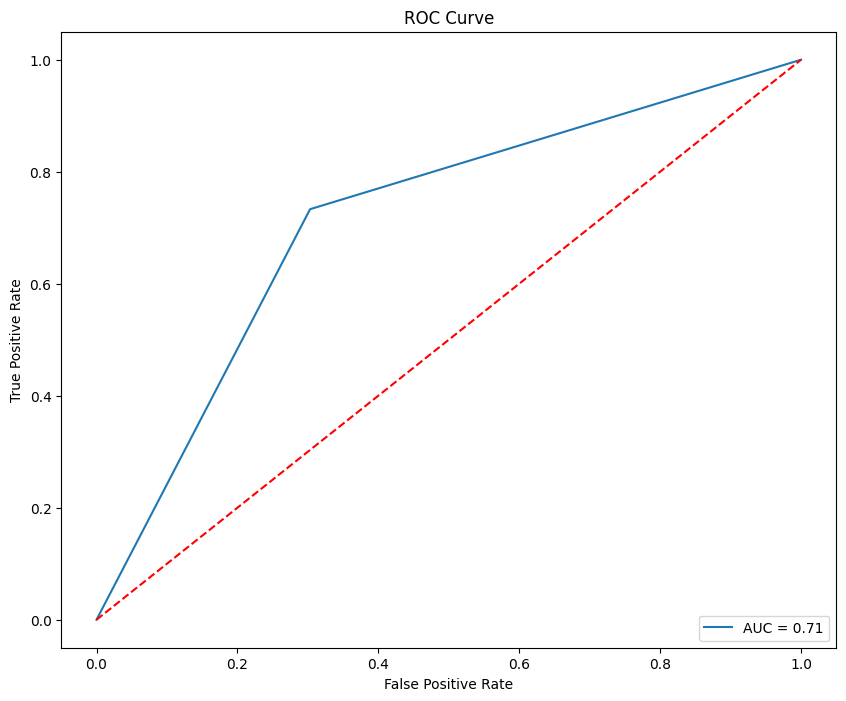

In [67]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_pred_binary)
print(f"AUC-ROC: {auc:.2f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()